# Stance Detection Using Multi-Layer Perceptron


`Multi-Layer Perceptron`  
`AraStance Dataset`  
`Stance Detection` `Arabic Language`

---

In this notebook, we rely on very simple multi-layer perceptron to classify the stances of the articles in the AraStance dataset. The dataset was introduced in the paper:  
```
AraStance: A Multi-Country and Multi-Domain Dataset of Arabic Stance Detection for Fact Checking.
```
The perceptron we experiment with is inspired by the paper:
```
A simple but tough-to-beat baseline for the Fake News Challenge stance detection task
```

## Packages

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from utils import AraStanceData, load_stop_words, stance_to_int, evaluate

## Raw data

- Download the raw data:

In [ ]:
!wget https://github.com/Tariq60/arastance/archive/refs/heads/main.zip
!unzip /content/main.zip

- Let's start by reading the raw data:

In [ ]:
raw_train = AraStanceData("/content/arastance-main/data/train.jsonl")
raw_dev = AraStanceData("/content/arastance-main/data/dev.jsonl")
raw_test = AraStanceData("/content/arastance-main/data/test.jsonl")

print(f'# training instances: {len(raw_train.stances)}')
print(f'# validation instances: {len(raw_dev.stances)}')
print(f'# testing instances: {len(raw_test.stances)}')

# training instances: 2848
# validation instances: 569
# testing instances: 646


- Let's see an instance from the data:

In [ ]:
instance_no = 10
print(f"Claim text: {raw_train.claims[raw_train.article_claim[instance_no]]}")
print(f"Article text: {raw_train.articles[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim text: العثور على طلاسم سحرية على ستار الكعبة المشرفة
Article text: نفت الرئاسة العامة لشؤون المسجد الحرام والمسجد النبوي، ما تردد عن وجود سحر وطلاسم في ثوب الكعبة، مؤكدة أن ما عثر عليه هو ورقة تركها أحد الزوار تضمنت أدعية ظنًا منه أنها ستجلب له الخير. وكان عدد من منسوبي الرئاسة العامة لشؤون المسجد الحرام والمسجد النبوي قد عثروا على ورقة صغيرة الحجم موضوعة بطريقة مريبة بين خيوط إطار ثوب الكعبة المشرفة السفلي، فيما رجح مغردون أنها تتضمن سحرًا أو طلاسم. وأكد مصدر بالرئاسة العامة لشؤون الحرمين في تصريحات صحافية أنه تم تلقي بلاغ من منسوبي صيانة الكسوة عن وجود ورقة في أحد إطارات الكعبة المشرفة مصاغة بطريقة مريبة بخيوط الكعبة، حيث بادرت إدارة الهيئة بالمسجد الحرام هذا البلاغ وتم أخذ هذه الورقة التي لم يتضح أن بها سحر . وكان مغردون قد تداولوا مقطع فيديو يظهر لحظة العثور على الورقة في ثوب الكعبة مرجحين أنها سحر، داعين إلى سرعة التحقيق في الأمر وكشف الحقائق للناس.
Stance: Disagree


- Thus, the instances are triplets, Claim/Article/Stance.
- Note that the original language of the data is Arabic.

## Dataset

- First, we need to vectorize the data. To do so, we'll use tf-idf vectors to represent the instances:

In [ ]:
# lim_unigram is the size of the vocabulary or
# the top features ordered by term frequency across the corpus
lim_unigram = 4000
batch_size = 128

In [ ]:
nltk_stop_words, custom_stop_words = load_stop_words()
stop_words = nltk_stop_words + custom_stop_words

# to fit the vectorizer, we will only use the training data.
# Now, concatenate the pairs claims/articles
train_instances = [raw_train.claims[raw_train.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_train.articles)]

# fit the vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=lim_unigram, stop_words=stop_words)
tfidf_vectorizer = tfidf_vectorizer.fit(train_instances)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


- Now the vectorizer is fitted, we can start vectorizing the data:

In [ ]:
# we will use this function to vectorize the data using the fitted vectorizer
def vectorize(data):
  feature_vectors = []

  for idx in range(len(data.articles)):
    claim = data.claims[data.article_claim[idx]]
    article = data.articles[idx]

    # vectorize the pair into (lim_unigram,) sparse vectors each
    claim_tfidf = tfidf_vectorizer.transform([claim]).toarray()
    article_tfidf = tfidf_vectorizer.transform([article]).toarray()

    # find the similarity between claim and article vectors
    similarity = cosine_similarity(claim_tfidf, article_tfidf)

    # append the vectors and the similarity to construct (2 * lim_unigram + 1) vector
    feat_vec = np.squeeze(np.c_[claim_tfidf, article_tfidf, similarity])
    feature_vectors.append(tf.constant(feat_vec))

  return feature_vectors

train_features = vectorize(raw_train)
dev_features = vectorize(raw_dev)
test_features = vectorize(raw_test)

- Let's see a vectorized instance from the training data:

In [ ]:
instance_no = 10
print(f'shape of each feature vector is: {train_features[instance_no].shape}')
print(f'feature vectors are sparse: {train_features[instance_no]}')

shape of each feature vector is: (8001,)
feature vectors are sparse: [0.         0.         0.         ... 0.         0.         0.50467087]


- As you can see the representations are sparse and contain `2 * lim_unigram + 1` features.

- Now the features are ready, we can create the datasets we are going to use for the training and testing:

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_size = len(raw_train.stances)
dev_size = len(raw_dev.stances)

train_labels = [stance_to_int[s] for s in raw_train.stances]
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
train_dataset = train_dataset.shuffle(train_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

dev_labels = [stance_to_int[s] for s in raw_dev.stances]
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_features, dev_labels))
dev_dataset = dev_dataset.batch(batch_size)
dev_dataset = dev_dataset.cache().prefetch(buffer_size=AUTOTUNE)

test_labels = [stance_to_int[s] for s in raw_test.stances]
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
test_dataset = test_dataset.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

- Let's see a batch from the training dataset:

In [ ]:
batch, labels = next(iter(train_dataset))
print(f'shape of the batch is: {batch.shape}')
print(f'batch instances: {batch.numpy()}')
print(f'batch labels: {labels.numpy()}')

shape of the batch is: (128, 8001)
batch instances: [[0.         0.         0.         ... 0.         0.         0.07688795]
 [0.         0.         0.         ... 0.         0.         0.11334158]
 [0.         0.         0.         ... 0.         0.         0.03866361]
 ...
 [0.         0.         0.         ... 0.         0.         0.01295991]
 [0.         0.         0.         ... 0.         0.         0.096208  ]
 [0.         0.         0.         ... 0.         0.         0.43701551]]
batch labels: [3 3 3 0 3 0 3 3 0 3 3 3 0 3 0 2 3 2 3 0 3 3 3 1 3 3 0 3 3 1 3 3 3 0 3 3 0
 0 3 3 3 0 3 1 3 3 0 3 0 2 3 3 3 0 3 0 0 3 0 3 2 0 3 3 3 2 0 3 3 1 2 0 3 3
 0 0 3 3 2 3 0 3 1 3 3 3 3 1 3 3 3 2 3 1 3 0 3 3 0 1 3 3 1 1 3 3 3 3 0 1 1
 3 3 3 3 3 3 3 1 3 0 3 0 0 1 3 3 0]


## Model

- Now the datasets are ready, we can work on the model:

In [ ]:
# several preliminary experiments suggested these hyperparameters
lr = 6e-3
epochs = 100
patience = 3

- As simple as it is, the following model is going to overfit the training data. Stick around for a possible interpretation and suggestion for solutions:

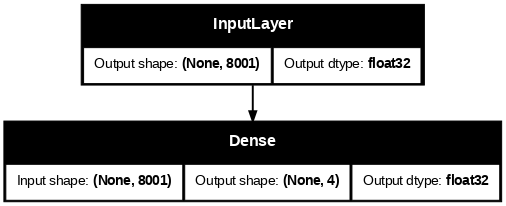

In [ ]:
inputs = tf.keras.Input(shape=(2*lim_unigram+1,), dtype=tf.float32)
outputs = tf.keras.layers.Dense(4)(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, dpi=70)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 8001)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          32,008 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,008 (125.03 KB)

 Trainable params: 32,008 (125.03 KB)

 Non-trainable params: 0 (0.00 B)

## Training

- Compile the model:

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

- Watch the validation loss during training.
- Stop the training when validation loss doesn't improve for `patience` consecutive  epochs.
- Train the model:

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)]
history = model.fit(
    x=train_dataset,
    epochs=epochs,
    validation_data=dev_dataset,
    callbacks=callbacks
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5146 - loss: 1.2439 - val_accuracy: 0.5413 - val_loss: 1.0917
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6326 - loss: 0.9125 - val_accuracy: 0.5764 - val_loss: 1.0226
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7243 - loss: 0.7746 - val_accuracy: 0.6239 - val_loss: 0.9562
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7722 - loss: 0.6724 - val_accuracy: 0.6485 - val_loss: 0.9074
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8117 - loss: 0.5958 - val_accuracy: 0.6696 - val_loss: 0.8715
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8403 - loss: 0.5358 - val_accuracy: 0.6924 - val_loss: 0.8435
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8637 - loss: 0.4869 - val_accuracy: 0.7170 - val_loss: 0.8209
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8826 - loss: 0.4461 - val_accuracy: 0.

- Plot learning curves:

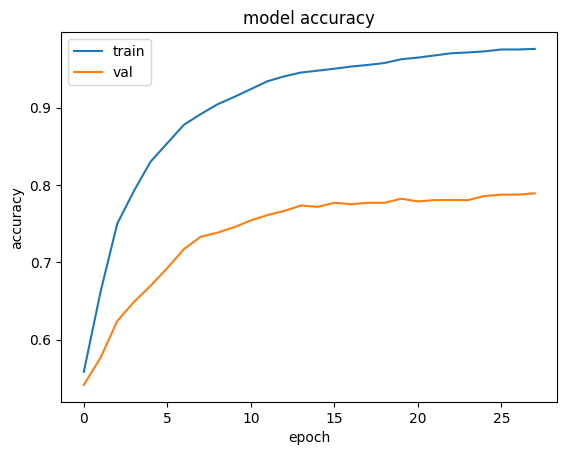

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

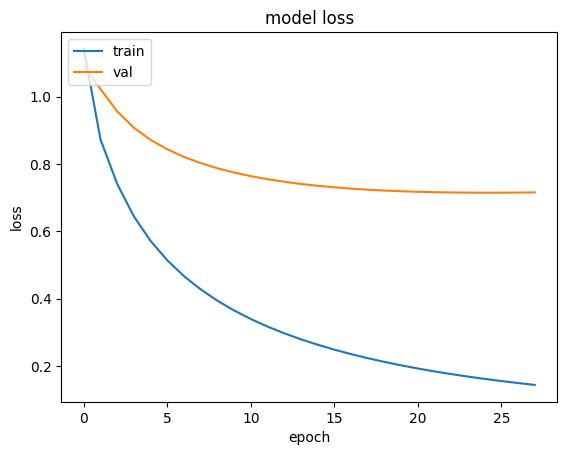

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

- It is clear that the model is overfitting the training data. Scroll down for a word about that.

## Evaluation

In [ ]:
loss, accuracy, f1score, mf1score = evaluate(model, dev_dataset, dev_labels)
print("Loss                       :", loss)
print("Accuracy                   :", accuracy)
print("F1 score                   :", f1score)
print("Macro F1 score             :", mf1score)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7789 - loss: 0.7129 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Loss                       : 0.7154432535171509
Accuracy                   : 0.789103690685413
F1 score                   : [0.76923077 0.74285714 0.50909091 0.85321101]
Macro F1 score             : 0.7185974575882832


In [ ]:
loss, accuracy, f1score, mf1score = evaluate(model, test_dataset, test_labels)
print("Loss                       :", loss)
print("Accuracy                   :", accuracy)
print("F1 score                   :", f1score)
print("Macro F1 score             :", mf1score)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8572 - loss: 0.5320
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Loss                       : 0.6460802555084229
Accuracy                   : 0.8204334365325078
F1 score                   : [0.82711864 0.71666667 0.39583333 0.88604353]
Macro F1 score             : 0.7064155444996636


## A first thought on Overfitting

In the following, I will propose (needs further investigation) the following propositions:
- The model's failure to improve on the validation set, despite increasing training set performance, suggests that it's not simply learning spurious patterns. Instead, it's struggling to capture the underlying concepts of the 'disagree' and 'discuss' classes. These classes are inherently complex and underrepresented across the three sets. Consequently, early stopping or regularization, while potentially mitigating overfitting, could also hinder the model's capacity (ability) to learn valuable patterns from the 'unrelated' and 'agree' classes, leading to lower overall performance.

- Our empirical findings corroborate this, as we observed substantial performance degradation on both validation and testing sets when these techniques were applied.

![image not found](tab_arastance.png)

Let's take a look at the statistics of the dataset (the table is from AraStance paper):
- The dataset exhibits a clear class imbalance, with the 'unrelated' class significantly outnumbering the others. Additionally, the 'disagree' and 'discuss' classes are underrepresented compared to 'agree' and 'unrelated'.
- In fact, the inherent complexity of the 'disagree' and 'discuss' classes contributes to their classification difficulty:
  - **Unrelated class:** Easily identifiable through simple similarity measures, as these instances contain articles that tackle different topics than their claims.
  - **Agree class:** The same measures will be very good at classifying the 'agree' instances, because the language of confirmation overlaps very much with main premises.
  - **Discuss class:** Those measures will not be as good at classifying the 'discuss' class despite the possibility of overlapping words. Discussing involves giving more details and different viewpoints on the same topics. It requires more complex comprehension skills.
  - **Disagree class:** The same way, in order to classify the 'disagree' instances, you need to detect the disagreement signal which could use simple negation terms or more complex negations like changing dates, quantities, or introducing opposing concepts (e.g. Sky is Blue vs. Sky is Black).

- The relative lower representations of the 'discuss' and 'disagree' classes across the three sets exacerbates the classification challenge.

